In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"priyanshi30080107","key":"0cf6c9455648daae0a18474fecb5bde5"}'}

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'


In [4]:
!kaggle datasets download -d ruchikakumbhar/calories-burnt-prediction


Dataset URL: https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction
License(s): CC0-1.0
  0% 0.00/236k [00:00<?, ?B/s]
100% 236k/236k [00:00<00:00, 338MB/s]


In [5]:
!unzip calories-burnt-prediction.zip -d calories_dataset

Archive:  calories-burnt-prediction.zip
  inflating: calories_dataset/calories.csv  


**Importing Libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import time

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance


import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load calories.csv and exercise.csv
calories_df = pd.read_csv('calories_dataset/calories.csv')

# Preview the data
print(calories_df.head())

    User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  \
0  14733363    male   68   190.0    94.0      29.0       105.0       40.8   
1  14861698  female   20   166.0    60.0      14.0        94.0       40.3   
2  11179863    male   69   179.0    79.0       5.0        88.0       38.7   
3  16180408  female   34   179.0    71.0      13.0       100.0       40.5   
4  17771927  female   27   154.0    58.0      10.0        81.0       39.8   

   Calories  
0     231.0  
1      66.0  
2      26.0  
3      71.0  
4      35.0  


In [8]:
calories_df.shape

(15000, 9)

In [9]:
print(calories_df.isnull().sum())


User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


In [10]:
calories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [11]:
calories_df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


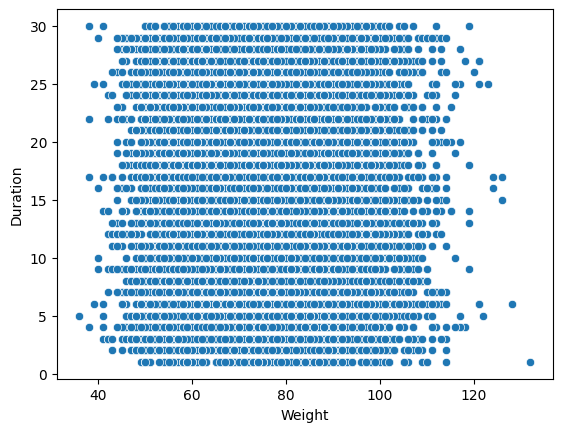

In [12]:
sb.scatterplot(x='Weight', y='Duration', data=calories_df)
plt.show()

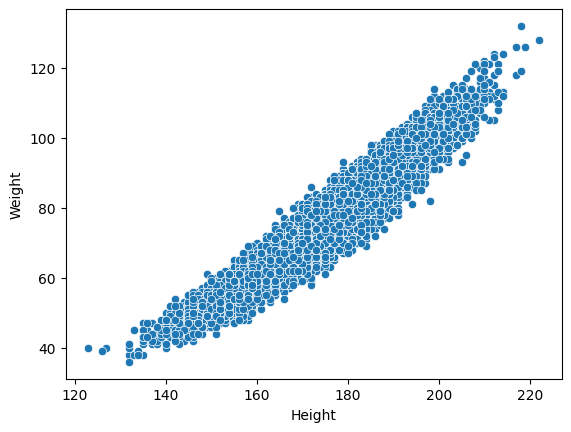

In [13]:
sb.scatterplot(x='Height', y='Weight', data=calories_df)
plt.show()

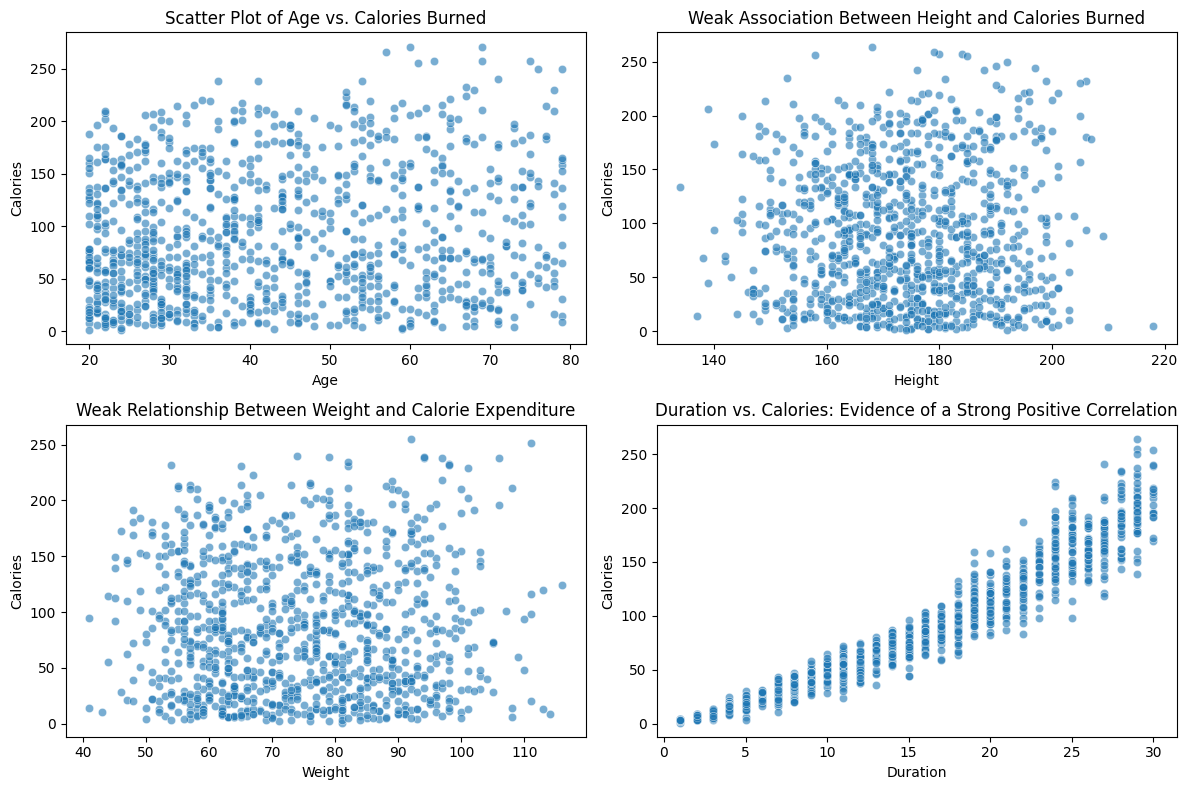

In [14]:
features = ['Age', 'Height', 'Weight', 'Duration']

# Custom titles for each subplot
custom_titles = [
    'Scatter Plot of Age vs. Calories Burned',
    'Weak Association Between Height and Calories Burned',
    'Weak Relationship Between Weight and Calorie Expenditure',
    'Duration vs. Calories: Evidence of a Strong Positive Correlation'
]

plt.figure(figsize=(12, 8))

for i, (col, title) in enumerate(zip(features, custom_titles), 1):
    plt.subplot(2, 2, i)
    x = calories_df.sample(1000)
    sb.scatterplot(x=col, y='Calories', data=x, alpha=0.6)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Calories')

plt.tight_layout()
plt.show()


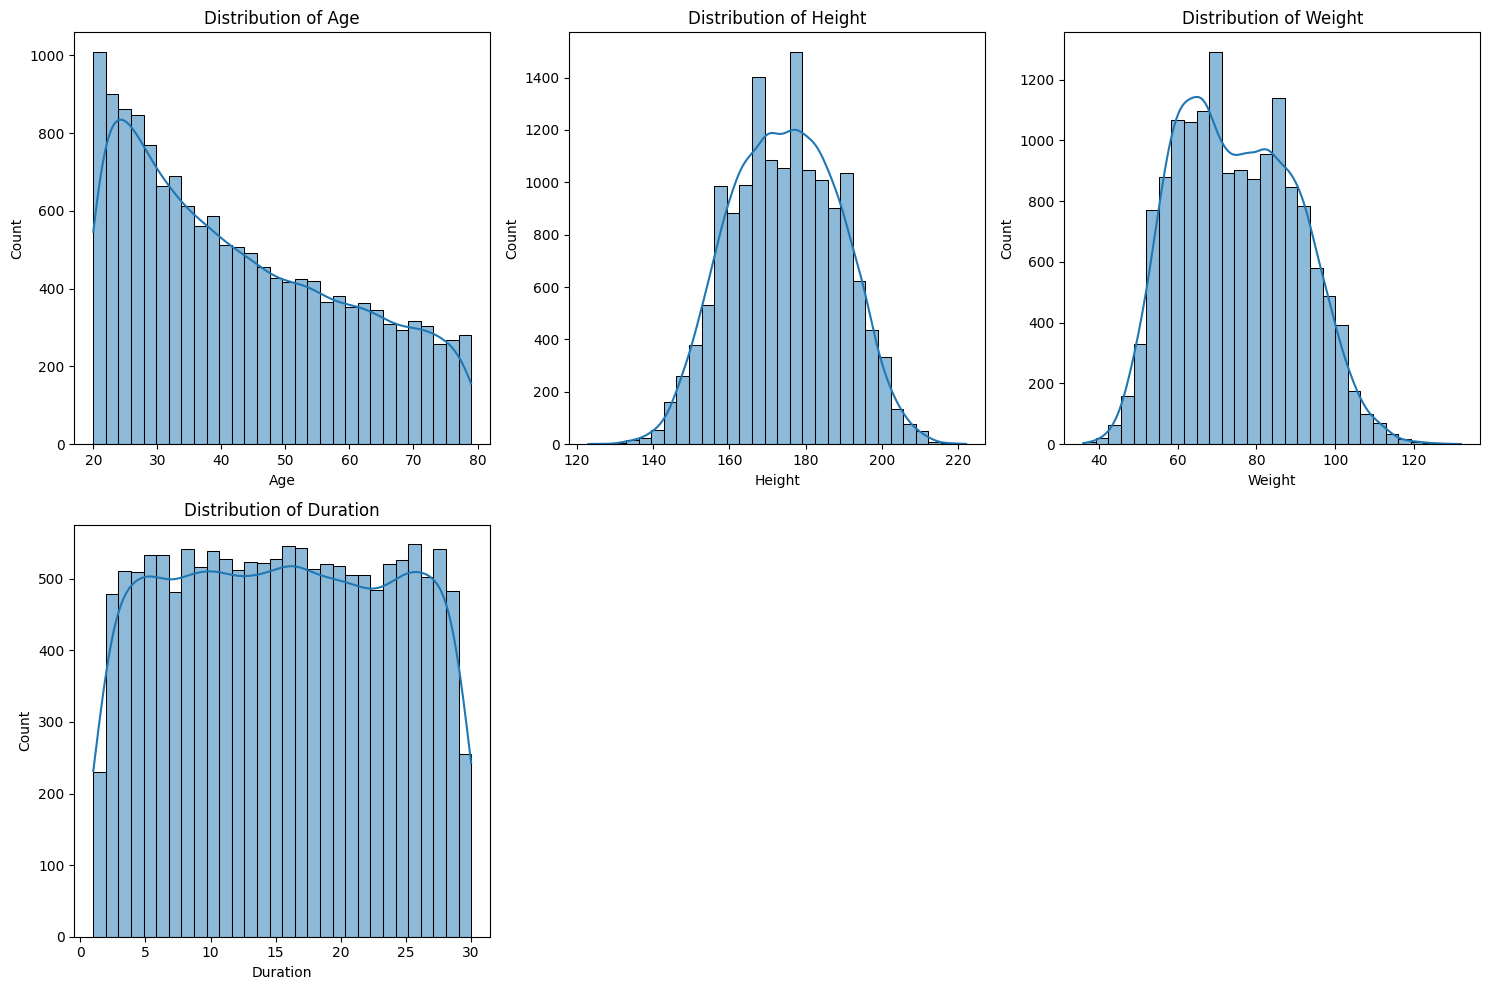

In [15]:
plt.figure(figsize=(15, 10))

# histograms plot through features for outlier detection
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)  # Adjusting rows/columns
    sb.histplot(calories_df[feature], bins=30, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [16]:
#encoding

calories_df.replace({'male': 0, 'female': 1},
           inplace=True)
calories_df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


In [17]:
print(calories_df['Gender'].value_counts()[0]) #males
print(calories_df['Gender'].value_counts()[1]) #females

7447
7553


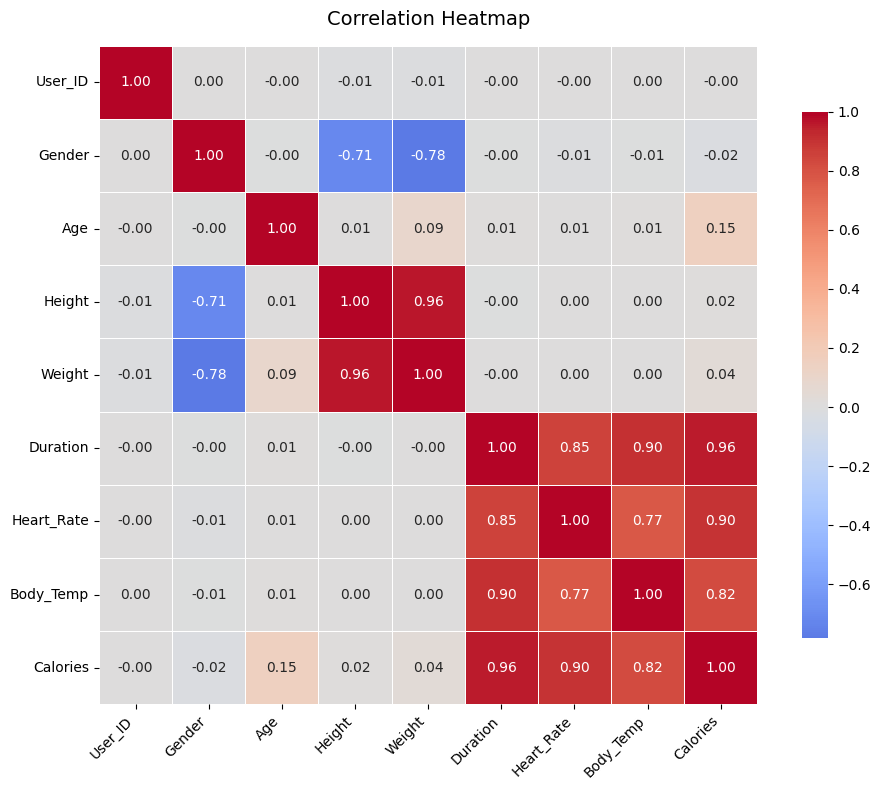

In [18]:
# Compute correlation matrix
corr_matrix = calories_df.corr(numeric_only=True)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
#drop columns
features = calories_df.drop(['User_ID', 'Calories'], axis=1)
target = calories_df['Calories'].values


#splitting data
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((12000, 7), (3000, 7))

In [20]:
#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Machine Learning Models (ML)
Trained the following models:

Linear Regression
XGBoost
Gradient Boosting
Random Forest
K-Nearest Neighbors

Evaluated models using:

R² Score
RMSE
Computation Time

In [21]:
ml_results, dl_results = [], []

models = {'Linear Regression': LinearRegression(),
          'XGBoost': XGBRegressor(),
          'GBR': GradientBoostingRegressor(),
          'KNN': KNeighborsRegressor(),
          'Random': RandomForestRegressor()}

trained_models = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    time_taken = end_time - start_time
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ml_results.append({'Model': name, 'R^2 Score': r2, 'RMSE': rmse, 'Time (s)': end_time - start_time})
    trained_models[name] = model

    print(f"Model: {name}")
    print(f"R^2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Time Taken: {time_taken:.2f} seconds\n")

Model: Linear Regression
R^2 Score: 0.9673
RMSE: 11.4889
Time Taken: 0.05 seconds

Model: XGBoost
R^2 Score: 0.9989
RMSE: 2.1375
Time Taken: 0.58 seconds

Model: GBR
R^2 Score: 0.9968
RMSE: 3.6147
Time Taken: 3.44 seconds

Model: KNN
R^2 Score: 0.9876
RMSE: 7.0659
Time Taken: 0.10 seconds

Model: Random
R^2 Score: 0.9982
RMSE: 2.7066
Time Taken: 7.15 seconds



In [22]:
#print(calories_df.dtypes)


In [23]:
#print(X['Height'].unique())


# **DL Model**

Keras Sequential Model

Deep Learning Models (DL)

1. Keras Sequential Model (3 hidden layers, ReLU, Dropout)

Metrics: R², RMSE, Time

In [24]:
# Building Deep Learning Model with 3 hidden layers
dl_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

dl_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start_time = time.time()
dl_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
end_time = time.time()

y_pred_dl = dl_model.predict(X_test_scaled).flatten()
r2_dl = r2_score(y_test, y_pred_dl)
rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))
time_dl = end_time - start_time

dl_results.append({'Model': 'Deep Learning', 'R^2 Score': r2_dl, 'RMSE': rmse_dl, 'Time (s)': time_dl})

print(f"Deep Learning Model \n")
print(f"R^2 Score: {r2_dl:.4f}")
print(f"RMSE: {rmse_dl:.4f}")
print(f"Time Taken: {time_dl:.2f} seconds")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Learning Model 

R^2 Score: 0.9991
RMSE: 1.8713
Time Taken: 54.07 seconds


2. Wide & Deep Learning Model (functional API combining linear and deep paths)

Early stopping used
Metrics: R², RMSE, Time

In [25]:
# Define input
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Wide part: Linear layer
wide = Dense(1)(input_layer)

# Deep part: Multiple Dense layers with dropout
deep = Dense(256, activation='relu')(input_layer)
deep = Dropout(0.3)(deep)
deep = Dense(128, activation='relu')(deep)
deep = Dropout(0.3)(deep)
deep = Dense(64, activation='relu')(deep)
deep_output = Dense(1)(deep)

# Combine wide and deep
combined = Concatenate()([wide, deep_output])
final_output = Dense(1)(combined)

# Define model
wide_deep_model = Model(inputs=input_layer, outputs=final_output)
wide_deep_model.compile(optimizer='adam', loss='mse')

# Train the model
start_time = time.time()
wide_deep_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
end_time = time.time()
y_pred_wd = wide_deep_model.predict(X_test_scaled).flatten()
r2_wd = r2_score(y_test, y_pred_wd)
rmse_wd = np.sqrt(mean_squared_error(y_test, y_pred_wd))
time_wd = end_time - start_time

dl_results.append({'Model': 'Wide & Deep Learning', 'R^2 Score': r2_wd, 'RMSE': rmse_wd, 'Time (s)': time_wd})


print(f"Wide & Deep Model \n")
print(f"R^2: {r2_wd:.4f}")
print(f"RMSE: {rmse_wd:.4f}")
print(f"Time: {time_wd:.2f} sec")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Wide & Deep Model 

R^2: 0.9991
RMSE: 1.9479
Time: 28.42 sec


**Comaprison**

In [26]:
# Convert to DataFrames
ml_df = pd.DataFrame(ml_results)
dl_df = pd.DataFrame(dl_results)

# Display tables
print("\n *Machine Learning Models Comparison \n")
print(ml_df)

print("\n *Deep Learning Model Comparison \n")
print(dl_df)
print()


 *Machine Learning Models Comparison 

               Model  R^2 Score       RMSE  Time (s)
0  Linear Regression   0.967294  11.488940  0.049797
1            XGBoost   0.998868   2.137512  0.584871
2                GBR   0.996762   3.614715  3.438406
3                KNN   0.987629   7.065863  0.095438
4             Random   0.998185   2.706619  7.146541

 *Deep Learning Model Comparison 

                  Model  R^2 Score      RMSE   Time (s)
0         Deep Learning   0.999132  1.871291  54.072661
1  Wide & Deep Learning   0.999060  1.947914  28.422328



Shap XAI

In [27]:
!pip install shap

In [28]:
import shap

In [29]:
print(len(X_test))


3000


In [33]:
# 1) Prepare a small sample for SHAP to speed up computation
#    Using 100 test samples here
sample_X = X_test.sample(300, random_state=42)
sample_X_scaled = X_test_scaled[X_test.index.isin(sample_X.index)]

Shap for ML

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

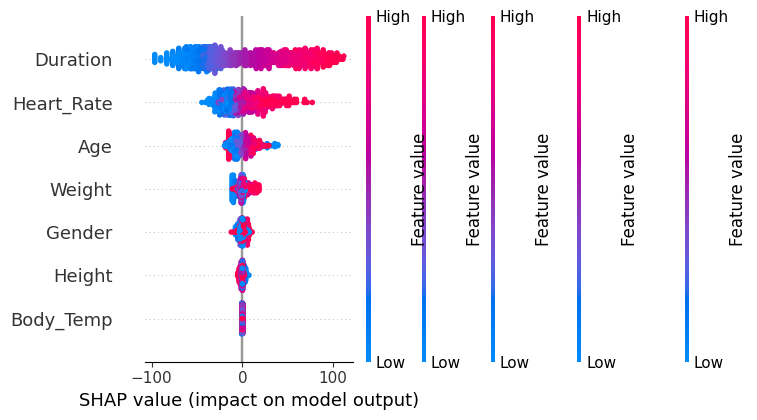

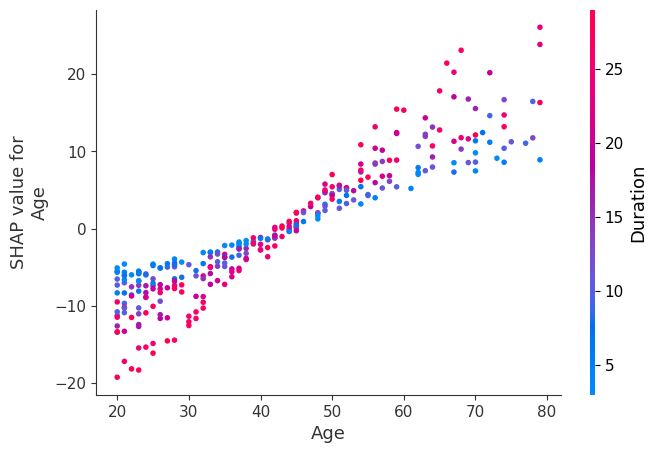

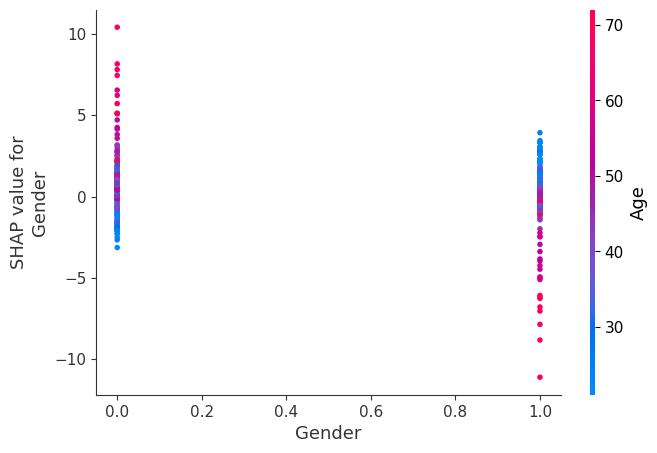

In [34]:
# Linear Regression
explainer_lin = shap.KernelExplainer(trained_models['Linear Regression'].predict, shap.kmeans(X_train, 10))  # Using KernelExplainer because linear models can be handled generically
shap_values_lin = explainer_lin.shap_values(sample_X)
shap.summary_plot(shap_values_lin, sample_X, show=False)

# K-Nearest Neighbors Regressor
explainer_knn = shap.KernelExplainer(trained_models['KNN'].predict, shap.kmeans(X_train, 10))
shap_values_knn = explainer_knn.shap_values(sample_X)
shap.summary_plot(shap_values_knn, sample_X, show=False)

# Gradient Boosting Regressor
explainer_gbr = shap.TreeExplainer(trained_models['GBR'])
shap_values_gbr = explainer_gbr.shap_values(sample_X)
shap.summary_plot(shap_values_gbr, sample_X, show=False)

# Random Forest Regressor
explainer_rf = shap.TreeExplainer(trained_models['Random'])
shap_values_rf = explainer_rf.shap_values(sample_X)
shap.summary_plot(shap_values_rf, sample_X, show=False)

# XGBoost Regressor
explainer_xgb = shap.TreeExplainer(trained_models['XGBoost'])
shap_values_xgb = explainer_xgb.shap_values(sample_X)
shap.summary_plot(shap_values_xgb, sample_X, show=False)

# Summary plots to check bias by Age and Gender
shap.dependence_plot("Age", shap_values_rf, sample_X)
shap.dependence_plot("Gender", shap_values_rf, sample_X)



Shap for DL model

In [ ]:
# Keras Sequential Model (3 hidden layers, ReLU, Dropout)
# Use DeepExplainer for Keras models (requires tensorflow/keras installed)

# Prepare a smaller background dataset for DeepExplainer
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]
explainer_dl = shap.DeepExplainer(dl_model, background)
shap_values_dl = explainer_dl.shap_values(sample_X_scaled)
shap.summary_plot(shap_values_dl, sample_X, show=False)

# Wide & Deep Learning Model
# DeepExplainer can also handle functional API models
background_wd = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]
explainer_wd = shap.DeepExplainer(wide_deep_model, background_wd)
shap_values_wd = explainer_wd.shap_values(sample_X_scaled)
shap.summary_plot(shap_values_wd, sample_X, show=False)

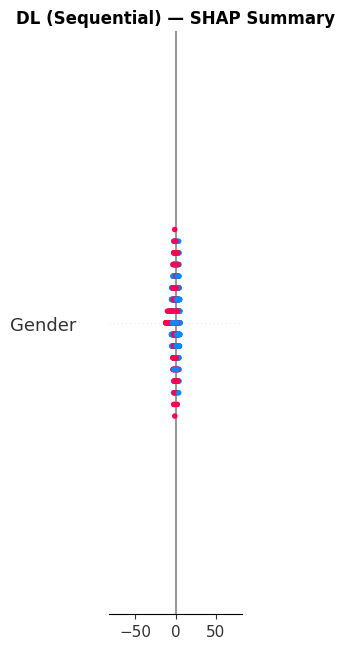

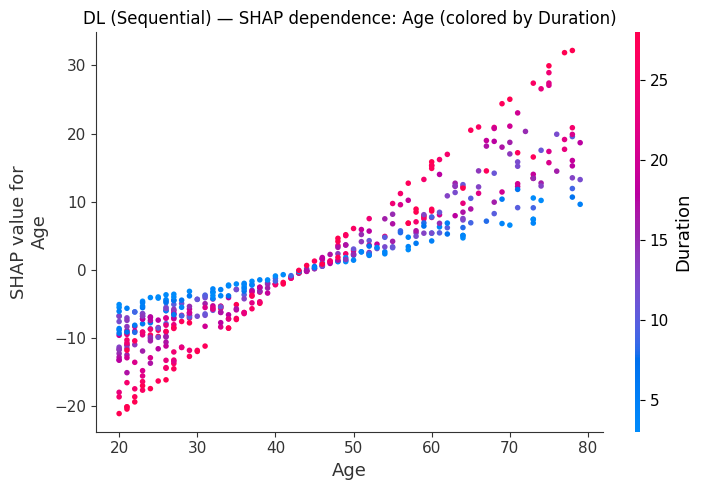

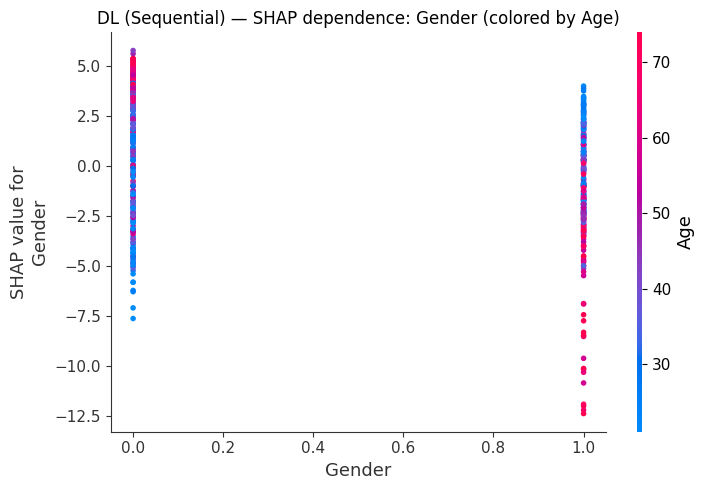

AttributeError: 'Explanation' object has no attribute 'expected_value'

In [42]:
# ===== SHAP for DL models (Sequential + Wide&Deep with SAME single input) =====
# Requirements: shap, tensorflow/keras, matplotlib, numpy, pandas
# Assumes you already have:
#   - dl_model, wide_deep_model (Keras models)
#   - X_train_scaled, X_test_scaled (numpy arrays in the SAME preprocessing/column order as training)
#   - X_test (DataFrame with the same columns, for pretty names)
#   - Columns include 'Age', 'Gender', 'Duration' if you want those dependence plots

RNG_SEED = 42
BG_MAX = 200     # background size for explainer
SMP_MAX = 500    # sample size for plotting

# Feature names for pretty plots
feature_names = list(X_test.columns)

# ---------------------- Background / Samples ------------------
rng = np.random.default_rng(RNG_SEED)
bg_n  = min(BG_MAX, X_train_scaled.shape[0])
smp_n = min(SMP_MAX, X_test_scaled.shape[0])

bg_idx  = rng.choice(X_train_scaled.shape[0], bg_n, replace=False)
smp_idx = rng.choice(X_test_scaled.shape[0],  smp_n,  replace=False)

background = X_train_scaled[bg_idx].astype(np.float32)
sample_X_scaled = X_test_scaled[smp_idx].astype(np.float32)
sample_X_df = X_test.iloc[smp_idx].copy()

# ---------------------- Helpers -------------------------------
def make_explainer_keras_single_input(model, background_arr):
    """Prefer DeepExplainer; fall back to GradientExplainer for TF/SHAP compatibility."""
    try:
        return shap.DeepExplainer(model, background_arr)
    except Exception:
        return shap.GradientExplainer((model, model.inputs), background_arr)

def get_shap_values(explainer, sample_arr):
    """Return a (n_samples, n_features) numpy array of SHAP values for regression."""
    vals = explainer.shap_values(sample_arr)
    # Some SHAP/TF combos return a list even for single-output regression
    if isinstance(vals, list):
        vals = vals[0]
    return np.asarray(vals)

def plot_summary(shap_vals, X_df, title):
    shap.summary_plot(shap_vals, features=X_df, feature_names=list(X_df.columns), show=False)
    plt.title(title, fontweight="bold")
    plt.tight_layout(); plt.show()

def plot_dependences(shap_vals, X_df, pairs, title_prefix):
    for feat, color_by in pairs:
        if feat in X_df.columns:
            interaction = color_by if (color_by in X_df.columns) else None
            shap.dependence_plot(feat, shap_vals, X_df, interaction_index=interaction, show=False)
            extra = f" (colored by {interaction})" if interaction else ""
            plt.title(f"{title_prefix} — SHAP dependence: {feat}{extra}")
            plt.tight_layout(); plt.show()

def plot_waterfall(shap_vals, X_df, explainer, title_prefix, index=0, max_display=12):
    """Version-robust waterfall plot."""
    # Base value retrieval (handles old/new SHAP)
    base_val = None
    if hasattr(explainer, "expected_value"):
        ev = explainer.expected_value
        # Ensure base_val is a numpy array, even if it's a scalar tensor initially
        base_val = np.array(ev)
        if np.ndim(base_val) > 0:
            base_val = base_val[0] # Take the first element for single output
    # Fallback if not present
    if base_val is None:
        # Reasonable fallback; not used if explainer provides expected_value
        base_val = float(np.mean(shap_vals))

    exp = shap.Explanation(
        values=shap_vals[index],
        base_values=base_val,
        data=X_df.iloc[index].values,
        feature_names=list(X_df.columns)
    )
    # Try new API first; if unavailable, fallback to legacy
    try:
        shap.plots.waterfall(exp, max_display=max_display, show=False)
    except Exception:
        shap.plots._waterfall.waterfall_legacy(exp, max_display=max_display)
    plt.title(f"{title_prefix} — SHAP Waterfall (sample {index})", fontweight="bold")
    plt.tight_layout(); plt.show()

def mean_abs_shap(shap_vals, cols):
    return pd.Series(np.abs(shap_vals).mean(axis=0), index=cols).sort_values(ascending=False)

def group_mean_abs_shap(shap_vals, X_df, group_col):
    out = {}
    if group_col in X_df.columns:
        for g in sorted(X_df[group_col].dropna().unique()):
            mask = (X_df[group_col] == g).values
            if mask.sum() > 0:
                out[g] = pd.Series(np.abs(shap_vals[mask]).mean(axis=0),
                                   index=X_df.columns).sort_values(ascending=False)
    return out

# ----------------------- Run for models -----------------------
def run_shap_for_model(model, model_tag):
    explainer = make_explainer_keras_single_input(model, background)
    shap_vals = get_shap_values(explainer, sample_X_scaled)

    # Global importance
    plot_summary(shap_vals, sample_X_df, f"{model_tag} — SHAP Summary")

    # Dependence examples (adjust features to what you actually have)
    pairs = [("Age", "Duration"), ("Gender", "Age")]
    plot_dependences(shap_vals, sample_X_df, pairs, model_tag)

    # Local (waterfall)
    plot_waterfall(shap_vals, sample_X_df, explainer, model_tag, index=0, max_display=12)

    # Print aggregates for text reporting
    glob = mean_abs_shap(shap_vals, sample_X_df.columns)
    print(f"\nTop 10 global mean |SHAP| — {model_tag}:\n{glob.head(10)}")

    if "Gender" in sample_X_df.columns:
        gm = group_mean_abs_shap(shap_vals, sample_X_df, "Gender")
        for g, s in gm.items():
            print(f"\nTop 5 mean |SHAP| for Gender={g} — {model_tag}:\n{s.head(5)}")

    if "Age" in sample_X_df.columns:
        # Example: younger vs older split by median
        age_median = sample_X_df["Age"].median()
        bins = pd.Series(np.where(sample_X_df["Age"] < age_median, "Younger", "Older"),
                         index=sample_X_df.index, name="AgeGroup")
        gm_age = group_mean_abs_shap(shap_vals, pd.concat([sample_X_df, bins], axis=1), "AgeGroup")
        for g, s in gm_age.items():
            print(f"\nTop 5 mean |SHAP| for {g} — {model_tag}:\n{s.head(5)}")

    return shap_vals

# ===== Execute for BOTH models with SAME input =====
shap_values_seq = run_shap_for_model(dl_model, "DL (Sequential)")
shap_values_wd  = run_shap_for_model(wide_deep_model, "Wide&Deep")

# (Optional) quick side-by-side top feature names
top_seq = mean_abs_shap(shap_values_seq, feature_names).head(10)
top_wd  = mean_abs_shap(shap_values_wd,  feature_names).head(10)
print("\nTop features comparison (mean |SHAP|):")
print(pd.DataFrame({"Sequential": top_seq, "Wide&Deep": top_wd}).fillna(0.0))

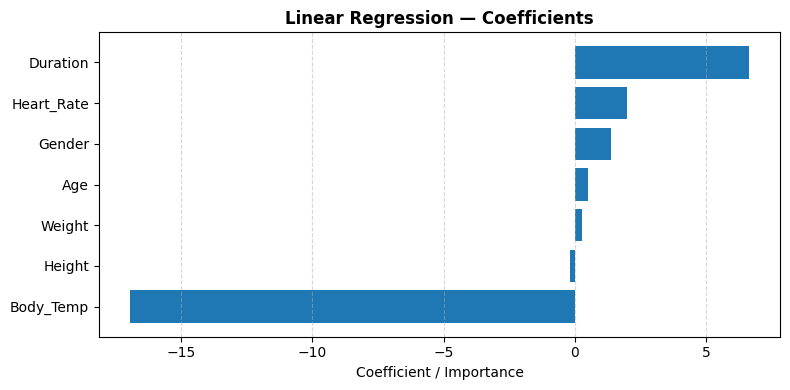

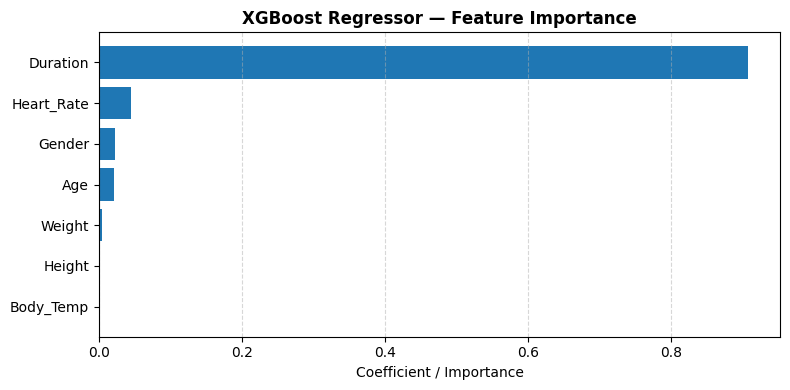

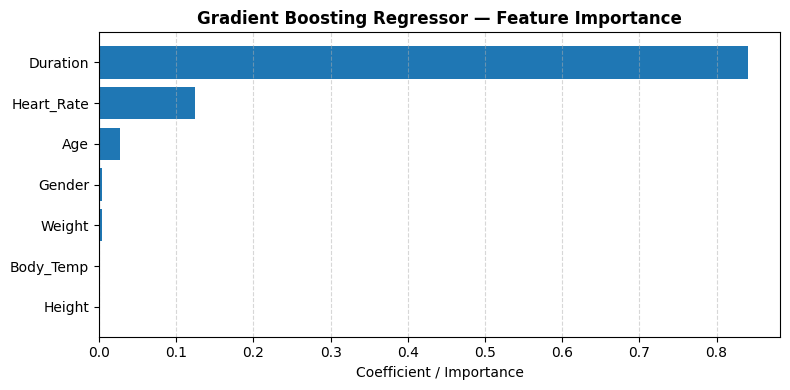

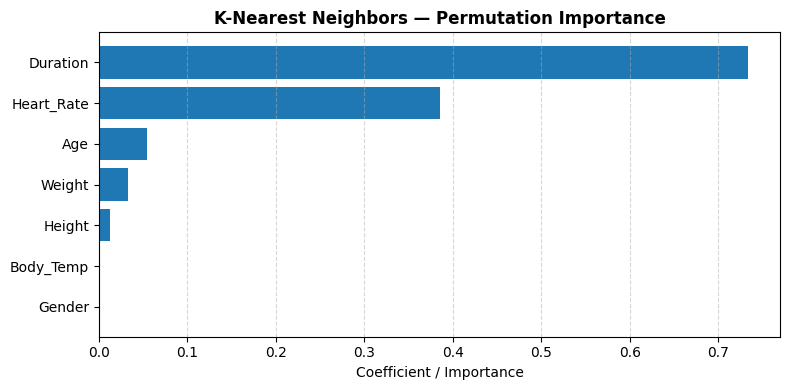

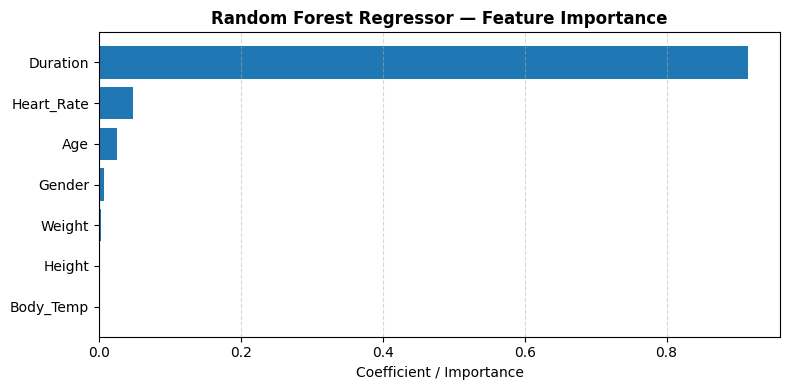

<Figure size 1000x400 with 0 Axes>

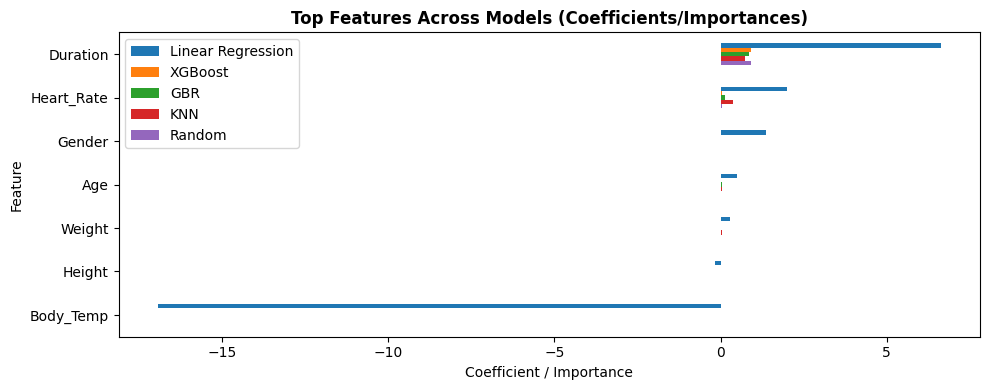

In [35]:
def _plot_barh(df_imp, title, xlabel="Coefficient / Importance"):
    df_imp = df_imp.sort_values("Importance", ascending=True)
    plt.figure(figsize=(8, max(4, 0.35*len(df_imp))))
    plt.barh(df_imp["Feature"], df_imp["Importance"])
    plt.title(title, fontweight="bold")
    plt.xlabel(xlabel)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def get_importance_df(model, model_name, X, y=None, scoring=None, n_repeats=10, random_state=42):
    """Return a DataFrame with columns: Feature, Importance for a given model."""
    feature_names = X.columns if hasattr(X, "columns") else [f"f{i}" for i in range(X.shape[1])]

    # Intrinsic importances
    if model_name == "Linear Regression" and hasattr(model, "coef_"):
        vals = np.ravel(model.coef_)
        return pd.DataFrame({"Feature": feature_names, "Importance": vals})

    if model_name in {"GBR", "Random", "XGBoost"} and hasattr(model, "feature_importances_"):
        vals = np.ravel(model.feature_importances_)
        return pd.DataFrame({"Feature": feature_names, "Importance": vals})

    # Fallback: permutation importance (works for KNN and any model)
    if y is not None:
        pi = permutation_importance(model, X, y, scoring=scoring, n_repeats=n_repeats, random_state=random_state)
        return pd.DataFrame({"Feature": feature_names, "Importance": pi.importances_mean})

    # If nothing applies
    return None

# ------------- per-model plots -----------------
# Choose a regression scoring for permutation importance (higher is better)
# For regression a good choice is negative RMSE or R^2; we'll use R^2 here.
scoring = "r2"

for name, model in trained_models.items():
    imp_df = get_importance_df(model, name, X_test, y_test, scoring=scoring)  # use test set for PI
    if imp_df is None:
        print(f"[skip] No importance available for {name}.")
        continue

    # Nice titles that match your nomenclature
    title_map = {
        "Linear Regression": "Linear Regression — Coefficients",
        "KNN": "K-Nearest Neighbors — Permutation Importance",
        "GBR": "Gradient Boosting Regressor — Feature Importance",
        "Random": "Random Forest Regressor — Feature Importance",
        "XGBoost": "XGBoost Regressor — Feature Importance",
    }
    _plot_barh(imp_df, title_map.get(name, f"{name} — Importance"))


In [ ]:


# 1) Make named DataFrames for the scaled sets so SHAP can map values ↔ names
feature_cols = X_train.columns  # the exact columns used to train the DL models
X_train_s = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_s  = pd.DataFrame(X_test_scaled,  columns=feature_cols, index=X_test.index)

# 2) Pick the same rows for both scaled and unscaled (names only come from the DataFrame)
idx = np.random.RandomState(42).choice(X_test_s.index, size=100, replace=False)
sample_X_s = X_test_s.loc[idx]     # scaled values with names
# (If you need the unscaled for reporting, keep X_test.loc[idx] separately, but don't mix it in summary_plot)

# 3) Keras Sequential model (single-output regression)
background = X_train_s.sample(100, random_state=42).values  # numpy for DeepExplainer
explainer_dl = shap.DeepExplainer(dl_model, background)

sv_dl_list = explainer_dl.shap_values(sample_X_s.values)  # returns a list for Keras
sv_dl = sv_dl_list[0]                                     # take first output (regression)

shap.summary_plot(sv_dl, sample_X_s, feature_names=feature_cols)  # uses the same columns

# 4) Wide & Deep model
background_wd = X_train_s.sample(100, random_state=0).values
explainer_wd = shap.DeepExplainer(wide_deep_model, background_wd)

sv_wd_list = explainer_wd.shap_values(sample_X_s.values)
sv_wd = sv_wd_list[0]

shap.summary_plot(sv_wd, sample_X_s, feature_names=feature_cols)


In [ ]:
# Define age bins and labels
age_bins = [0, 25, 40, 60, 100]
age_labels = ['<25', '25-40', '40-60', '60+']

In [ ]:
# Create the AgeGroup column
calories_df['AgeGroup'] = pd.cut(calories_df['Age'], bins=age_bins, labels=age_labels)

In [ ]:
calories_df

**AGE bias ML models**

In [ ]:
# Evaluating each ML model by age group
X_test_df = pd.DataFrame(X_test, columns=features.columns, index=X_test.index) # Use X_test's index
# Convert y_test to a pandas Series with the same index as X_test_df
y_test_series = pd.Series(y_test, index=X_test_df.index)

age_group_results = {}

for model_name, model in trained_models.items():
    age_group_results[model_name] = {}
    for group in ['<25', '25-40', '40-60', '60+']:
        # Use X_test_df's index to filter the age group
        group_indices = calories_df[calories_df['AgeGroup'] == group].index.intersection(X_test_df.index)
        X_group = X_test_df.loc[group_indices]
        y_group = y_test_series.loc[group_indices]  # Use the pandas Series for indexing

        # Check if there are samples for the group
        if not X_group.empty:
            preds = model.predict(X_group)
            r2 = r2_score(y_group, preds)
            rmse = np.sqrt(mean_squared_error(y_group, preds))

            age_group_results[model_name][group] = {'R2': r2, 'RMSE': rmse}
        else:
            age_group_results[model_name][group] = {'R2': None, 'RMSE': None} # Handle empty groups

# Display results
for model_name, results in age_group_results.items():
    print(f"\nModel: {model_name}")
    for group, metrics in results.items():
        if metrics['R2'] is not None:
             print(f"  Age Group {group} -> R²: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.2f}")
        else:
             print(f"  Age Group {group} -> No data in test set for this group")

**Visualization**

In [ ]:
# Convert the evaluation dictionary to a DataFrame
results_list = []
for model, groups in age_group_results.items():
    for group, metrics in groups.items():
        results_list.append({
            'Model': model,
            'Age Group': group,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE']
        })
results_df = pd.DataFrame(results_list)

# Using color-blind friendly palette
sns.set_palette("colorblind")

# R² Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=results_df, x='Age Group', y='R2', hue='Model')
plt.title('R² Score by Age Group & Model', fontweight='bold')
plt.ylabel('R² Score', fontweight='bold')
plt.xlabel('Age Group', fontweight='bold')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#value labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()



In [ ]:
# RMSE Plot
plt.figure(figsize=(10, 4))
ay = sns.barplot(data=results_df, x='Age Group', y='RMSE', hue='Model')
plt.title('RMSE by Age Group & Model', fontweight='bold')
plt.ylabel('Root Mean Squared Error', fontweight='bold')
plt.xlabel('Age Group', fontweight='bold')

ay.yaxis.grid(True, linestyle='--', alpha=0.7)
ay.set_axisbelow(True)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#value labels to each bar
for container in ay.containers:
    ay.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
results_df

**AGE BIAS DL model **

In [ ]:
# Convert X_test_scaled to DataFrame
X_test_dl = pd.DataFrame(X_test_scaled, columns=features.columns, index=X_test.index)
y_test_dl = pd.Series(y_test, index=X_test_dl.index)

# Evaluate DL model by age group
dl_age_group_results = {}

for group in ['<25', '25-40', '40-60', '60+']:
    # Find indices for group in test set
    group_indices = calories_df[calories_df['AgeGroup'] == group].index.intersection(X_test_dl.index)
    X_group = X_test_dl.loc[group_indices]
    y_group = y_test_dl.loc[group_indices]

    if not X_group.empty:
        preds = dl_model.predict(X_group).flatten()  # flatten() ensures shape matches y_group
        r2 = r2_score(y_group, preds)
        rmse = np.sqrt(mean_squared_error(y_group, preds))
        dl_age_group_results[group] = {'R2': r2, 'RMSE': rmse}
    else:
        dl_age_group_results[group] = {'R2': None, 'RMSE': None}

# Print results
print("\nDeep Learning Model Performance by Age Group")
for group, metrics in dl_age_group_results.items():
    if metrics['R2'] is not None:
        print(f"Age Group {group} -> R²: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.2f}")
    else:
        print(f"Age Group {group} -> No data in test set")


In [ ]:
# Convert X_test_scaled to DataFrame
X_test_wd = pd.DataFrame(X_test_scaled, columns=features.columns, index=X_test.index)
y_test_wd = pd.Series(y_test, index=X_test_wd.index)

# Evaluate DL model by age group
wd_age_group_results = {}

for group in ['<25', '25-40', '40-60', '60+']:
    # Find indices for group in test set
    group_indices = calories_df[calories_df['AgeGroup'] == group].index.intersection(X_test_wd.index)
    X_group = X_test_wd.loc[group_indices]
    y_group = y_test_wd.loc[group_indices]

    if not X_group.empty:
        preds = wide_deep_model.predict(X_group).flatten()  # flatten() ensures shape matches y_group
        r2 = r2_score(y_group, preds)
        rmse = np.sqrt(mean_squared_error(y_group, preds))
        wd_age_group_results[group] = {'R2': r2, 'RMSE': rmse}
    else:
        wd_age_group_results[group] = {'R2': None, 'RMSE': None}

# Print results
print("\nWide-Deep Learning Model Performance by Age Group")
for group, metrics in wd_age_group_results.items():
    if metrics['R2'] is not None:
        print(f"Age Group {group} -> R²: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.2f}")
    else:
        print(f"Age Group {group} -> No data in test set")


In [ ]:
combined_results = []

#keras sequential
for group, metrics in dl_age_group_results.items():
    combined_results.append({
        'Model': 'Keras',
        'Age Group': group,
        'R² Score': metrics['R2']
    })

# Wide & Deep model
for group, metrics in wd_age_group_results.items():
    combined_results.append({
        'Model': 'Wide & Deep',
        'Age Group': group,
        'R² Score': metrics['R2']
    })

viz_df = pd.DataFrame(combined_results)

In [ ]:
sns.set_palette("colorblind")

# Create bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=viz_df, x='Age Group', y='R² Score', hue='Model')

# Titles and axis labels
plt.title('R² Score by Age Group and Model', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12, fontweight='bold')
plt.ylabel('R² Score', fontsize=12, fontweight='bold')

# Gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8)

# Legend outside
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Create RMSE-specific dataframe from ML, DL, and WD models
rmse_results = []

#keras sequential
for group, metrics in dl_age_group_results.items():
    rmse_results.append({
        'Model': 'Keras',
        'Age Group': group,
        'RMSE': metrics['RMSE']
    })

# Wide & Deep model
for group, metrics in wd_age_group_results.items():
    rmse_results.append({
        'Model': 'Wide & Deep',
        'Age Group': group,
        'RMSE': metrics['RMSE']
    })

# Final DataFrame for RMSE
rmse_df = pd.DataFrame(rmse_results)

In [ ]:
plt.figure(figsize=(10, 4))
ay = sns.barplot(data=rmse_df, x='Age Group', y='RMSE', hue='Model')
plt.title('RMSE by Age Group & Model', fontweight='bold')
plt.ylabel('Root Mean Squared Error', fontweight='bold')
plt.xlabel('Age Group', fontweight='bold')

# Add gridlines and legend
ay.yaxis.grid(True, linestyle='--', alpha=0.7)
ay.set_axisbelow(True)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Add value labels
for container in ay.containers:
    ay.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

In [11]:
# import IPython
# notebook_name = 'CaloriesBurnt_MLDL.ipynb'  # replace with your notebook name
# IPython.notebook.save(notebook_name)

AttributeError: module 'IPython' has no attribute 'notebook'

In [1]:
!git config --global user.email 'tarapriyanka0107@gmail.com'
!git config --global user.name 'itsmeptara'


In [2]:
!echo "Hello from Colab"


Hello from Colab


In [3]:
!git clone https://github.com/itsmeptara/Masters_DA_Calories-Burnt-Prediction.git


Cloning into 'Masters_DA_Calories-Burnt-Prediction'...


In [6]:
!cp /content/CaloriesBurnt_MLDL.ipynb /Masters_DA_Calories-Burnt-Prediction/


cp: cannot stat '/content/CaloriesBurnt_MLDL.ipynb': No such file or directory


In [7]:
!ls /content


Masters_DA_Calories-Burnt-Prediction  sample_data


In [9]:
import os
os.listdir()


['.config', 'Masters_DA_Calories-Burnt-Prediction', 'sample_data']

In [10]:
!ls /content/Masters_DA_Calories-Burnt-Prediction


In [8]:
import shutil

shutil.copy('/content/CaloriesBurnt_MLDL.ipynb',
            '/content/Masters_DA_Calories-Burnt-Prediction/')


FileNotFoundError: [Errno 2] No such file or directory: '/content/CaloriesBurnt_MLDL.ipynb'